In [0]:
basePath = '/gdrive'

In [0]:
from google.colab import drive
drive.mount(basePath)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
image_width = 150
image_height = 150
batch_size = 125
data_directory = basePath + "/My Drive/Data"
train_directory = data_directory + "/Train"
test_directory = data_directory + "/Test"

In [0]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_directory,
                                              #  color_mode="grayscale",
                                               shuffle=True,
                                               target_size=(image_width, image_height),
                                               class_mode='sparse')


image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=test_directory,
                                                #  color_mode="grayscale",
                                                 target_size=(image_width, image_height),
                                                 class_mode='sparse')

Found 5232 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


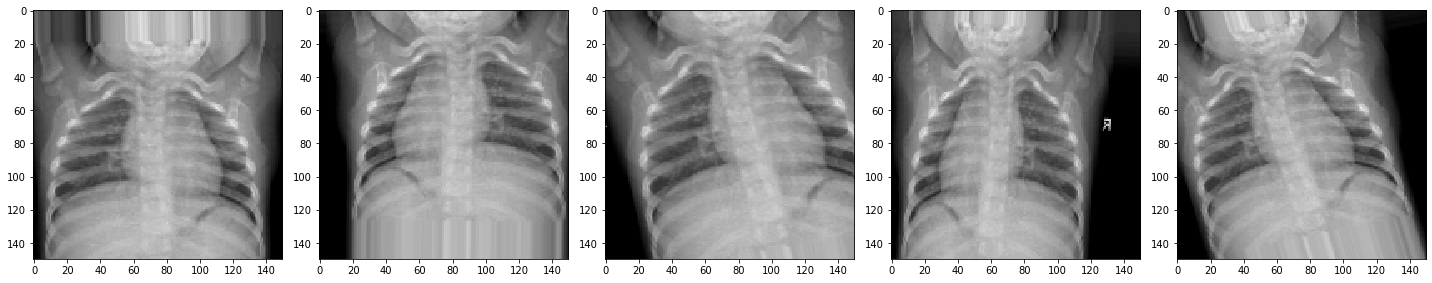

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [0]:
num_nor_tr = len(os.listdir(train_directory + '/Normal'))
num_bac_tr = len(os.listdir(train_directory + '/Bacterial'))
num_vir_tr = len(os.listdir(train_directory + '/Viral'))

num_nor_val = len(os.listdir(test_directory + '/Normal'))
num_bac_val = len(os.listdir(test_directory + '/Bacterial'))
num_vir_val = len(os.listdir(test_directory + '/Viral'))

total_train = num_nor_tr + num_bac_tr + num_vir_tr
total_val = num_nor_val + num_bac_val + num_vir_val

total_train, total_val

(5232, 624)

In [0]:
checkpoint_filepath = basePath + '/My Drive/Data/Checkpoints/model checkpoint epoch-{epoch:02d} loss-{loss:.2f} accuracy-{accuracy:.2f}.hdf5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                                monitor='loss', 
                                verbose=0, 
                                save_best_only=True, 
                                save_weights_only=False, 
                                mode='auto', 
                                save_freq=1)

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=train_data_gen.image_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # tf.keras.layers.Conv2D(64, (2,2), activation='relu', input_shape=train_data_gen.image_shape),
    # tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

epochs=250
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(batch_size))),
    callbacks=[checkpoint_callback]
)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 149, 149, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

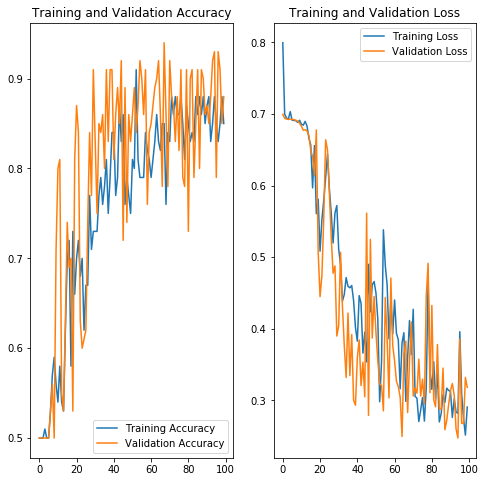

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)





plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()